Logs   
- [2023/03/08]   
  Restart this notebook if you change the scratch library

- [2023/05/03]   
  We divided this chapter into two parts.
  The first part is up to Topic Modeling

In [1]:
import re
import requests
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import json

from bs4 import BeautifulSoup
from collections import defaultdict, Counter
from typing import List, Dict, Tuple, Iterable
from IPython.display import display
from scratch.linear_algebra import LinearAlgebra as la
from scratch.linear_algebra import Vector
from scratch.deep_learning import DeepLearning as dl
from scratch.deep_learning import \
  Tensor, Layer, Sequential, Linear, SoftmaxCrossEntropy, Momentum, \
  GradientDescent

In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  'font.size': 16,
  'grid.alpha': 0.25})

In this chapter we are going to learn how to do computational on a language
dataset

## Word Clouds

Word clouds can be useful to put each word into a contextual space rather
than nice looking word cloud with different size

<img src="./datasets/neat-word-cloud.png" width=400>

In [3]:
# The following a data sciece-related buzzwords,
# The first number represents how frequently it appear in job posting
# The second number represents how frequently it appears on resumes
data = [ 
  ("big data", 100, 15), ("Hadoop", 95, 25), ("Python", 75, 50), 
  ("R", 50, 40), ("machine learning", 80, 20), ("statistics", 20, 60), 
  ("data science", 60, 70), ("analytics", 90, 3), ("team player", 85, 85), 
  ("dynamic", 2, 90), ("synergies", 70, 0), ("actionable insights", 40, 30), 
  ("think out of the box", 45, 10), ("self-starter", 30, 50), 
  ("customer focus", 65, 15), ("thought leadership", 35, 35)]

In [4]:
def text_size(total: int) -> float:
  """equals 8 if total is 0, 28 if total is 200""" 
  return 8 + total / 200 * 20

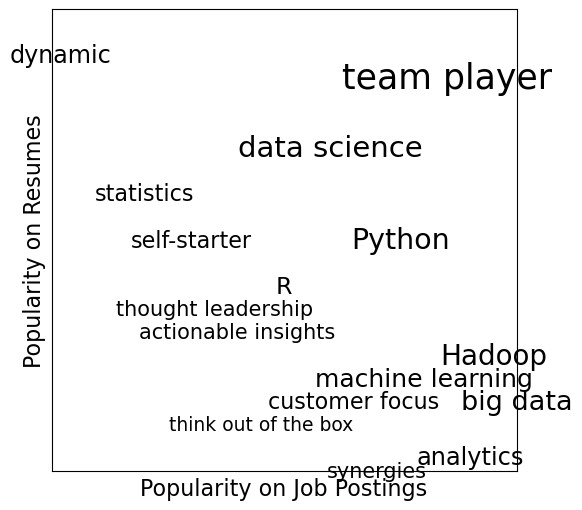

In [5]:
fig, ax = plt.subplots(figsize=(6, 6))

for word, job_popularity, resume_popularity in data:
  ax.text(job_popularity, resume_popularity, word, 
          ha="center", va="center", 
          size=text_size(job_popularity + resume_popularity)) 

ax.set_xlabel("Popularity on Job Postings")
ax.set_ylabel("Popularity on Resumes")

ax.axis([0, 100, 0, 100])

ax.set_xticks([])
ax.set_yticks([])

plt.show(fig)


## n-Gram Language Models

We have a task to create a bunch of essays by learning a corpus of
documents. We start with Mike Loukides's essay ["What Is Data Science?"](http://oreil.ly/1Cd6ykN)

In [6]:
# replace unicode character of apostrophes by literal apostropes
def fix_unicode(text: str) -> str:
  return text.replace(u"\u2019", "'")

In [7]:
# Get the text
url = "http://radar.oreilly.com/2010/06/what-is-data-science.html"
html = requests.get(url).text
soup = BeautifulSoup(html, 'html5lib')

In [8]:
# Split the downloaded text into a sequence of words and periods
# We have to update from article-body to entry-content
content = soup.find("div", "entry-content")      # find an entry-content div
regex = r"[\w']+|[\.]"                          # matches a word or a period


In [9]:
document = []
for paragraph in content("p"):
  words = re.findall(regex, fix_unicode(paragraph.text))
  document.extend(words)

document

['Sections',
 'Download',
 'this',
 'free',
 'report',
 "We've",
 'all',
 'heard',
 'it',
 'according',
 'to',
 'Hal',
 'Varian',
 'statistics',
 'is',
 'the',
 'next',
 'sexy',
 'job',
 '.',
 'Five',
 'years',
 'ago',
 'in',
 'What',
 'is',
 'Web',
 '2',
 '.',
 '0',
 'Tim',
 "O'Reilly",
 'said',
 'that',
 'data',
 'is',
 'the',
 'next',
 'Intel',
 'Inside',
 '.',
 'But',
 'what',
 'does',
 'that',
 'statement',
 'mean',
 'Why',
 'do',
 'we',
 'suddenly',
 'care',
 'about',
 'statistics',
 'and',
 'about',
 'data',
 'In',
 'this',
 'post',
 'I',
 'examine',
 'the',
 'many',
 'sides',
 'of',
 'data',
 'science',
 'the',
 'technologies',
 'the',
 'companies',
 'and',
 'the',
 'unique',
 'skill',
 'sets',
 '.',
 'The',
 'web',
 'is',
 'full',
 'of',
 'data',
 'driven',
 'apps',
 '.',
 'Almost',
 'any',
 'e',
 'commerce',
 'application',
 'is',
 'a',
 'data',
 'driven',
 'application',
 '.',
 "There's",
 'a',
 'database',
 'behind',
 'a',
 'web',
 'front',
 'end',
 'and',
 'middleware',
 '

We have to create a *bigrams model* for a given word and count the occurrences
for the next words.

In [10]:
transitions = defaultdict(list)
for prev, current in zip(document, document[1:]):
  transitions[prev].append(current)


transitions

defaultdict(list,
            {'Sections': ['Download'],
             'Download': ['this'],
             'this': ['free',
              'post',
              'database',
              'sounds',
              'data',
              'scale',
              'video',
              'difference',
              'animation',
              'is',
              'versatile',
              'into',
              'but'],
             'free': ['report'],
             'report': ["We've", 'from', 'only'],
             "We've": ['all', 'all', 'all'],
             'all': ['heard',
              'the',
              'of',
              'of',
              'carefully',
              'the',
              'in',
              'equipment',
              "you're",
              'heard',
              'data',
              'of',
              'heard',
              'locked',
              'at',
              'trying',
              'aspects',
              'tapped',
              'The'],
             'heard': ['it'

In [11]:
# Generate a sentence
def generate_using_bigrams(rng) -> str:
  current = "."       # this means the next word will start a sentence
  result = []
  while True:
    next_word_candidates = transitions[current]   # bigram (current, _)
    current = rng.choice(next_word_candidates)    # choose one at random

    result.append(current)
    if current == ".":
      return " ".join(result)

In [12]:
seed = 2023_05_03
rng = np.random.default_rng(seed)
generate_using_bigrams(rng)

"While rock solid consistency but to develop and Amazon's Elastic MapReduce to data exhaust that members had huge database or getting the point traditional data perhaps a database ."

The above generated sentence is gibberish. We try to improve it using 
*n-grams model*

In [13]:
trigram_transitions = defaultdict(list)
starts = []

for prev, current, next_ in zip(document, document[1:], document[2:]):
  if prev == ".":               # if the previous "word" was a period
    starts.append(current)      # then this is a start word

  trigram_transitions[(prev, current)].append(next_)

trigram_transitions

defaultdict(list,
            {('Sections', 'Download'): ['this'],
             ('Download', 'this'): ['free'],
             ('this', 'free'): ['report'],
             ('free', 'report'): ["We've"],
             ('report', "We've"): ['all'],
             ("We've", 'all'): ['heard', 'heard', 'heard'],
             ('all', 'heard'): ['it', 'a', 'the'],
             ('heard', 'it'): ['according'],
             ('it', 'according'): ['to'],
             ('according', 'to'): ['Hal'],
             ('to', 'Hal'): ['Varian'],
             ('Hal', 'Varian'): ['statistics'],
             ('Varian', 'statistics'): ['is'],
             ('statistics', 'is'): ['the', 'that', 'the'],
             ('is', 'the'): ['next',
              'next',
              'direct',
              'Hadoop',
              'grammar',
              'classic',
              'state',
              'heart'],
             ('the', 'next'): ['sexy', 'Intel', 'generation', 'decades'],
             ('next', 'sexy'): ['job'],
     

In [14]:
def generate_using_trigrams(rng) -> str:
  current = rng.choice(starts)
  prev = "."
  result = [current]
  while True:
    next_word_candidates = trigram_transitions[(prev, current)]
    next_word = rng.choice(next_word_candidates)

    prev, current = current, next_word
    result.append(current)

    if current == ".":
      return " ".join(result)

In [15]:
seed = 2023_05_01
rng = np.random.default_rng(seed)
generate_using_trigrams(rng)

'But the process of creating the group recommendation feature at LinkedIn .'

## Grammars

In [16]:
# Type alias to refer to grammars later
Grammar = Dict[str, List[str]]

# _S  : sentence
# _NP : noun phrase
# _VP : verb phrase 
# _N  : noun
# _A  : adjective
# _P  : 
# _V  : verb
# all the rule without _ (underscore) is a terminal (no need to expand)
grammar = {
  "_S"  : ["_NP _VP"],
  "_NP" : ["_N", "_A _NP _P _A _N"],
  "_VP" : ["_V", "_V _NP"],
  "_N"  : ["data science", "Python", "regression"],
  "_A"  : ["big", "linear", "logistic"],
  "_P"  : ["about", "near"],
  "_V"  : ["learns", "trains", "tests", "is"]
}

In [17]:
# A helper function to identify a terminals
def is_terminal(token: str) -> bool:
  return token[0] != "_"

In [18]:
# Expand a list of token into a sentence using given grammar
def expand(grammar: Grammar, tokens: List[str], rng, verbose=False) -> List[str]:
  if verbose:
    print(tokens)

  for i, token in enumerate(tokens):
    # If this is a terminal token, skip it.
    #print(token)
    if is_terminal(token):
      continue

    # Otherwise, it's a nonterminal token,
    # so we need to choose a replacement at random.
    replacement = rng.choice(grammar[token])

    if is_terminal(replacement):
      tokens[i] = replacement
    else:
      # Replacement could be, e.g., "_NP _VP", so we need to
      # split it on spaces and splice it in.
      tokens = tokens[:i] + replacement.split() + tokens[(i+1):]

    # Now call expand on the new list of tokens
    return expand(grammar, tokens, rng, verbose=verbose)
  
  # If we get here, we had all terminals and are done.
  return tokens, rng

In [19]:
def generate_sentence(grammar: Grammar, rng, verbose=False) -> List[str]:
  return expand(grammar, ["_S"], rng, verbose=verbose)

In [20]:
seed = 2023_05_02 
rng = np.random.default_rng(seed)

generate_sentence(grammar, rng, verbose=True);


['_S']
['_NP', '_VP']
['_N', '_VP']
['Python', '_VP']
['Python', '_V', '_NP']
['Python', 'trains', '_NP']
['Python', 'trains', '_N']
['Python', 'trains', 'data science']


Using data science to generate text is a neat trick; using it to *understand*
text is more magical.

## An Aside: Gibbs Sampling

In general, some distributions are harder to sample from.
Gibbs sampling helps us with a technique for generating samples
from multidimensional distributions when we only know some of the
conditional distributions

### Example: rolling two dices

$x$: the value of the first dice     
$y$: the sum of the dices.

The distribution of $y$ conditional on $x$: 
$x + 1$, $x + 2$, $x + 3$, $x + 4$, $x + 5$, $x + 6$

The distribution of $x$ conditional on $y$ is more complicated:
- if $y = 2$, then it is necessary that $x = 1$
- if $y = 3$, then it is necesary and equally likely that $x = 1$ or $x = 2$
- ...
- if $y = 11$, then  it is necesasry and equally likely that $x = 5$ or $x = 6$
- if $y = 12$, the it is necesasry that $x = 6$

In [21]:
def roll_a_dice(rng) -> int:
  return rng.choice([1, 2, 3, 4, 5, 6]) 

def direct_sample(rng) -> Tuple[int, int]:
  d1 = roll_a_dice(rng)
  d2 = roll_a_dice(rng)
  return d1, d1 + d2

def random_y_given_x(x: int, rng) -> int:
  """equally likely to be x + 1, x + 2, ..., x + 6""" 
  return x + roll_a_dice(rng)

def random_x_given_y(y: int, rng) -> int:
  # The minimum of y must be 2 where both dices are 1
  if y <= 7:
    # if the total is 7 or less, the first dice is equally likely to be
    # 1, 2, ..., (total - 1)
    return rng.integers(1, y)

  else:
    # if the total is 7 or more, the first dice is equally likely to be
    # (total - 6), (total - 5), ..., 6
    return rng.integers(y - 6, 7)

In [22]:
seed = 2023_05_03
rng = np.random.default_rng(seed)

x_data_dice = [roll_a_dice(rng) for _ in range(10)]
display(x_data_dice)

xy_data_dice = [direct_sample(rng) for _ in range(10)]
display(xy_data_dice)

display([random_y_given_x(x, rng) for x in x_data_dice])

display([random_x_given_y(y, rng) for y in np.array(xy_data_dice)[:,1]])

[5, 4, 4, 2, 4, 2, 4, 6, 3, 6]

[(2, 5),
 (2, 7),
 (5, 8),
 (5, 9),
 (2, 7),
 (4, 6),
 (3, 7),
 (1, 4),
 (3, 5),
 (1, 7)]

[10, 6, 7, 5, 9, 8, 7, 7, 6, 10]

[2, 1, 2, 3, 2, 3, 1, 1, 1, 2]

In real case, what we have is conditional probabilities to generate $y$ or $x$.
Then we can use gibbs sampling to generate all pairs of $x$ and $y$

In [23]:
def gibbs_sample(rng, num_iters: int = 100) -> Tuple[int, int]:
  x, y = 1, 2      # initial values do not really matter
  for _ in range(num_iters):
    x = random_x_given_y(y, rng)
    y = random_y_given_x(x, rng)

  return x, y

In [24]:
# Compare the distribution generated by Gibbs sample and and direct sample
def compare_distributions(rng, num_samples: int = 1000) \
  -> Dict[int, List[int]]:

  counts = defaultdict(lambda: [0, 0])
  for _ in range(num_samples):
    counts[gibbs_sample(rng)][0] += 1
    counts[direct_sample(rng)][1] += 1

  return counts

In [25]:
seed = 2023_05_03
rng = np.random.default_rng(seed)
comparison = compare_distributions(rng, num_samples=10_000)   # 21 secs

In [26]:
comparison_keys = comparison.keys()
comparison_vals = list(comparison.values())

gibbs_sample_count = np.array(comparison_vals)[:,0]
direct_sample_count = np.array(comparison_vals)[:,1]

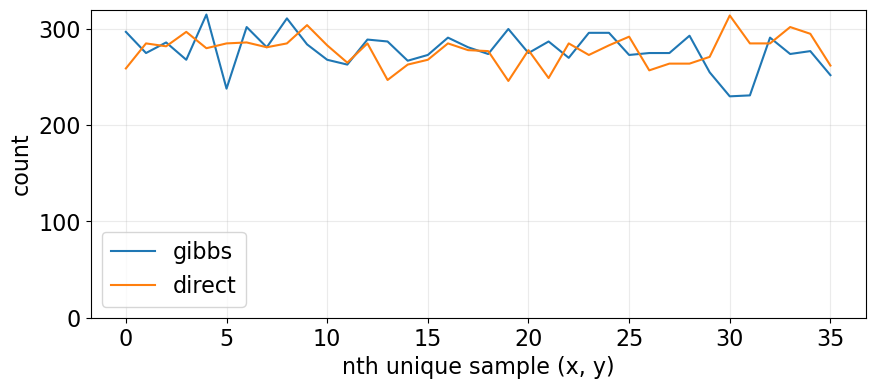

In [27]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(gibbs_sample_count, label="gibbs")
ax.plot(direct_sample_count, label="direct")

ax.set_ylim([0, 320])

ax.set_ylabel("count")
ax.set_xlabel("nth unique sample (x, y)")
ax.grid("on")
ax.legend(loc="best")

plt.show(fig)

## Topic Modeling

The following model uses LDA (Latent Dirichlet Allocation) to identify 
the topics that underlies documents.

The following assumptions is not detail enough in mathematical perspective 
for LDA technique:
1. There is some fixed number $K$ of topics
2. There is a random variable that assigns each topic an associated 
   distribution over words. You should think of this distribution as the 
   probability of seeing word $w$ given topic $k$.
3. There is another random variable that assigns each document a probability
   distribution over topics. You should think of this distribution as the 
   mixture of topics in document $d$.
4. Each word in a document was generated by first randomly picking a topic
   (from document's distribution of topics) and then randomly picking a word
   (from the topic's distribution of words)


From the given documents, we can estimate the likelihood that topic 1
produces a certain word $w$

$$
\frac{\text{How many times topic 1 produces word $w$}}{
      \text{How many times topic 1 produces any word}}
$$

Gibbs sampling is used when we want to generate the distribution over topics
for a specific word by sampling the topics for the word.

In [28]:
# A function to randomly choose an index based on an arbitrary set of weights
# If we give the function with weight [1, 1, 3], then on-fifth of the time
# it will return 0, one-fifth of the time it will return 1, and three fifth
# of the time it will return 2. Five is from 1 + 1 + 3 = 5.
def sample_from(weights: List[float], rng) -> int:
  """returns i with probability weights[i] / sum(weights)""" 
  total = sum(weights)
  rnd = total * rng.random()        # uniform between 0 and total
  for i, w in enumerate(weights):   
    rnd -= w                        # return the smallest i such that
    if rnd <= 0:                    # weights[0] + ... + weights[i] >= rnd
      return i

In [29]:
# A test script

# Draw 1000 times and count
seed = 2023_05_03
rng = np.random.default_rng(seed)
draws = Counter(sample_from([0.1, 0.1, 0.8], rng) for _ in range(1000))

print(draws[0])                           # 10 < draws[0] < 190
print(draws[1])                           # 10 < draws[1] < 190
print(draws[2])                           # 650 < draws[2] < 950
print(draws[0] + draws[1] + draws[2])     # == 1000

99
111
790
1000


In [30]:
# Our documents are our user's interests
documents = [
  ["Hadoop", "Big Data", "HBase", "Java", "Spark", "Storm", "Cassandra"],
  ["NoSQL", "MongoDB", "Cassandra", "HBase", "Postgres"],
  ["Python", "scikit-learn", "scipy", "numpy", "statsmodels", "pandas"],
  ["R", "Python", "statistics", "regression", "probability"],
  ["machine learning", "regression", "decision trees", "libsvm"],
  ["Python", "R", "Java", "C++", "Haskell", "programming languages"],
  ["statistics", "probability", "mathematics", "theory"],
  ["machine learning", "scikit-learn", "Mahout", "neural networks"],
  ["neural networks", "deep learning", "Big Data", "artificial intelligence"],
  ["Hadoop", "Java", "MapReduce", "Big Data"],
  ["statistics", "R", "statsmodels"],
  ["C++", "deep learning", "artificial intelligence", "probability"],
  ["pandas", "R", "Python"],
  ["databases", "HBase", "Postgres", "MySQL", "MongoDB"],
  ["libsvm", "regression", "support vector machines"]
]

# With the number of topics
K = 4


Create data structures to keep track some counters when calculating
sampling weights

In [31]:
# How many times each topic is assigned to each document

# a list of Counters, one for each document
document_topic_counts = [Counter() for _ in documents]

In [32]:
# How many times each word is assigned to each topic

# a list of Counters, one for each topic
topic_word_counts = [Counter() for _ in range(K)]

In [33]:
# The total number of words assigned to each topic

# a list of numbers, one for each topic
topic_counts = [0 for _ in range(K)]

In [34]:
# The total number of words contained in each document:

# a list of numbers, one for each document
document_lengths = [len(document) for document in documents]

In [35]:
# The number of distinct words
distinct_words = set(word for document in documents 
                      for word in document)
W = len(distinct_words)

In [36]:
# The number of documents
D = len(documents)

Now we define our conditional probability functions

In [37]:
def p_topic_given_document(topic: int, d: int, alpha: float = 0.1) -> float:
  """The fraction of words in document `d` that are assigned to 
     `topic` (plus some smoothing)""" 
  return ((document_topic_counts[d][topic] + alpha) 
           / (document_lengths[d] + K * alpha))


def p_word_given_topic(word: str, topic: int, beta: float = 0.1) -> float:
  """The fraction of words assigned to `topic` that equal `word` (plus some 
     smoothing)""" 
  return ((topic_word_counts[topic][word] + beta) 
          / (topic_counts[topic] + W * beta))

Use the above conditional probability function to create the 
weights for updating topics

There is a solid mathematica description why `topic_weight` is defined 
like the below function. For the practical purpose, we skip it.

In [38]:
def topic_weight(d: int, word: str, k: int) -> float:
  """Given a document and a word in that document, return the weight for 
     the kth topic"""
  return p_word_given_topic(word, topic) * p_topic_given_document(k, d)

def choose_new_topic(d: int, word: str, rng) -> int:
  return sample_from([topic_weight(d, word, k) for k in range(K)], rng)

We start by assigning every word to a random topic and populating
our counters appropriately

In [39]:
seed = 2023_05_03
rng = np.random.default_rng(seed)
document_topics = [[rng.integers(K) for word in document]
                      for document in documents]

# a list of Counters, one for each document
document_topic_counts = [Counter() for _ in documents]

# a list of Counters, one for each topic
topic_word_counts = [Counter() for _ in range(K)]

# a list of numbers, one for each topic
topic_counts = [0 for _ in range(K)]

# a list of numbers, one for each document
document_lengths = [len(document) for document in documents]

# The number of distinct words
distinct_words = set(word for document in documents 
                      for word in document)
W = len(distinct_words)

# The number of documents
D = len(documents)

for d in range(D):
  for word, topic in zip(documents[d], document_topics[d]):
    document_topic_counts[d][topic] += 1
    topic_word_counts[topic][word] += 1
    topic_counts[topic] += 1

In [40]:
display(document_topic_counts)

display(topic_word_counts)

display(topic_counts)

[Counter({2: 5, 0: 1, 1: 1}),
 Counter({3: 2, 1: 2, 0: 1}),
 Counter({0: 1, 2: 4, 1: 1}),
 Counter({1: 3, 3: 1, 2: 1}),
 Counter({2: 1, 0: 1, 1: 2}),
 Counter({0: 3, 3: 1, 2: 1, 1: 1}),
 Counter({1: 2, 3: 2}),
 Counter({0: 1, 1: 2, 2: 1}),
 Counter({0: 3, 1: 1}),
 Counter({1: 2, 0: 2}),
 Counter({1: 2, 0: 1}),
 Counter({3: 2, 0: 2}),
 Counter({0: 1, 1: 2}),
 Counter({0: 4, 1: 1}),
 Counter({1: 1, 3: 2})]

[Counter({'Java': 2,
          'HBase': 2,
          'Python': 2,
          'regression': 1,
          'R': 1,
          'Haskell': 1,
          'machine learning': 1,
          'neural networks': 1,
          'deep learning': 1,
          'Big Data': 2,
          'statsmodels': 1,
          'artificial intelligence': 1,
          'probability': 1,
          'pandas': 1,
          'databases': 1,
          'Postgres': 1,
          'MySQL': 1}),
 Counter({'Storm': 1,
          'MongoDB': 2,
          'Postgres': 1,
          'numpy': 1,
          'R': 3,
          'regression': 1,
          'probability': 1,
          'decision trees': 1,
          'libsvm': 2,
          'programming languages': 1,
          'statistics': 2,
          'theory': 1,
          'scikit-learn': 1,
          'neural networks': 1,
          'artificial intelligence': 1,
          'Hadoop': 1,
          'MapReduce': 1,
          'Python': 1}),
 Counter({'Hadoop': 1,
          'Big Data': 1,
          'HBase': 1

[21, 23, 13, 10]

Now we are going to get a joint sample of topics-word distrbution
and the documents-topic distribution using Giibs sampling and the conditional
probabilities defined previously

In [41]:
seed = 2023_05_03
rng = np.random.default_rng(seed)
document_topics = [[rng.integers(K) for word in document]
                      for document in documents]

# a list of Counters, one for each document
document_topic_counts = [Counter() for _ in documents]

# a list of Counters, one for each topic
topic_word_counts = [Counter() for _ in range(K)]

# a list of numbers, one for each topic
topic_counts = [0 for _ in range(K)]

# a list of numbers, one for each document
document_lengths = [len(document) for document in documents]

# The number of distinct words
distinct_words = set(word for document in documents 
                      for word in document)
W = len(distinct_words)

# The number of documents
D = len(documents)

for d in range(D):
  for word, topic in zip(documents[d], document_topics[d]):
    document_topic_counts[d][topic] += 1
    topic_word_counts[topic][word] += 1
    topic_counts[topic] += 1


for iter_ in tqdm.trange(1000):
  for d in range(D):
    for i, (word, topic) in enumerate(zip(documents[d], document_topics[d])):
      # remove this word / topic from the counts
      # so that it doesn't influence the weights
      document_topic_counts[d][topic] -= 1
      topic_word_counts[topic][word] -= 1
      topic_counts[topic] -= 1
      document_lengths[d] -= 1

      # choose a new topic based on the weights
      new_topic = choose_new_topic(d, word, rng)
      document_topics[d][i] = new_topic
      
      # and now add it back to the counts
      document_topic_counts[d][new_topic] += 1
      topic_word_counts[new_topic][word] += 1
      topic_counts[new_topic] += 1
      document_lengths[d] += 1

100%|██████████| 1000/1000 [00:00<00:00, 1765.57it/s]


Let's look at the five most heavily weighted words for each topic

In [42]:
for k, word_counts in enumerate(topic_word_counts):
  for word, count in word_counts.most_common():
    if count > 0:
      print(k, word, count)

0 Postgres 1
0 statistics 1
0 NoSQL 1
1 Java 2
1 Big Data 2
1 MongoDB 1
1 R 1
1 probability 1
1 programming languages 1
1 neural networks 1
1 artificial intelligence 1
1 Hadoop 1
1 MapReduce 1
1 Cassandra 1
1 deep learning 1
1 HBase 1
1 C++ 1
1 Haskell 1
2 scikit-learn 2
2 statsmodels 2
2 machine learning 2
2 regression 2
2 libsvm 2
2 scipy 1
2 pandas 1
2 Mahout 1
2 Python 1
2 Postgres 1
2 numpy 1
2 neural networks 1
2 artificial intelligence 1
2 R 1
2 support vector machines 1
2 decision trees 1
2 databases 1
2 MySQL 1
3 Python 3
3 probability 2
3 HBase 2
3 R 2
3 statistics 2
3 Cassandra 1
3 Java 1
3 mathematics 1
3 C++ 1
3 deep learning 1
3 regression 1
3 MongoDB 1
3 theory 1
3 Hadoop 1
3 Big Data 1
3 pandas 1
3 Spark 1
3 Storm 1


In [43]:
# Create topic_names based the above output
topic_names = ["databases and statistics",
               "programming language",
               "machine learning",
               "Big Data"]

In [44]:
for document, topic_counts in zip(documents, document_topic_counts):
  print(document)
  for topic, count in topic_counts.most_common():
    if count > 0:
      print(topic_names[topic], count)

['Hadoop', 'Big Data', 'HBase', 'Java', 'Spark', 'Storm', 'Cassandra']
Big Data 7
['NoSQL', 'MongoDB', 'Cassandra', 'HBase', 'Postgres']
programming language 3
databases and statistics 2
['Python', 'scikit-learn', 'scipy', 'numpy', 'statsmodels', 'pandas']
machine learning 6
['R', 'Python', 'statistics', 'regression', 'probability']
Big Data 5
['machine learning', 'regression', 'decision trees', 'libsvm']
machine learning 4
['Python', 'R', 'Java', 'C++', 'Haskell', 'programming languages']
programming language 5
Big Data 1
['statistics', 'probability', 'mathematics', 'theory']
Big Data 4
['machine learning', 'scikit-learn', 'Mahout', 'neural networks']
machine learning 4
['neural networks', 'deep learning', 'Big Data', 'artificial intelligence']
programming language 4
['Hadoop', 'Java', 'MapReduce', 'Big Data']
programming language 4
['statistics', 'R', 'statsmodels']
machine learning 2
databases and statistics 1
['C++', 'deep learning', 'artificial intelligence', 'probability']
Big Da

## Word Vectors

A lot of recent advances in NLP involves deep learning. Now we turn our
model using deep learning machinery.

The idea of word vectors, we represent each word using low-dimensional
vectors. Using this representation we can compare, add, feed into machine
learning models, or anything else with other techniques.

In [45]:
# Use cosine similarity to measure the similarity between wor vectors
def cosine_similarity(v1: Vector, v2: Vector) -> float:
  return la.dot(v1, v2) / np.sqrt(la.dot(v1, v1) * la.dot(v2, v2)) 


print(cosine_similarity([1., 1., 1.], [2., 2., 2.]))       # same direction
print(cosine_similarity([-1., -1.], [2., 2.]))             # opposite direction
print(cosine_similarity([1.0, 0.], [0., 1.]))              # orthogonal

1.0
-1.0
0.0


Now let's learn using word vectors with toy datasets

In [77]:
colors = ["red", "green", "blue", "yellow", "black", ""]
nouns = ["bed", "car", "boat", "cat"]
verbs = ["is", "was", "seems"]
adverbs = ["very", "quite", "extremely", ""]
adjectives = ["slow", "fast", "soft", "hard"]

seed = 2023_05
rng = np.random.default_rng(seed)
def make_sentence(rng) -> str:
  return " ".join([
    "The",
    rng.choice(colors),
    rng.choice(nouns),
    rng.choice(verbs),
    rng.choice(adverbs),
    rng.choice(adjectives),
    "."
  ])

NUM_SENTENCES = 50
sentences = [make_sentence(rng) for _ in range(NUM_SENTENCES)]
sentences

['The  bed seems extremely slow .',
 'The  cat was extremely hard .',
 'The black bed seems very soft .',
 'The  car was quite soft .',
 'The green bed was extremely fast .',
 'The black bed seems very soft .',
 'The green cat was  hard .',
 'The yellow bed was very fast .',
 'The green car was quite slow .',
 'The  cat is extremely slow .',
 'The yellow cat was quite slow .',
 'The green bed was quite soft .',
 'The red car is extremely soft .',
 'The blue boat was very slow .',
 'The red bed seems extremely hard .',
 'The green car is extremely soft .',
 'The red bed is very soft .',
 'The blue boat is quite hard .',
 'The green bed is extremely soft .',
 'The blue car seems  fast .',
 'The red car seems quite soft .',
 'The yellow car was  slow .',
 'The yellow car was very soft .',
 'The blue cat seems extremely slow .',
 'The blue bed is  fast .',
 'The red car was quite hard .',
 'The black boat was quite slow .',
 'The yellow car seems very hard .',
 'The green car was extremely

We want to do one-hot encoding using the following `Vocabulary` class

In [61]:
class Vocabulary(object):
  def __init__(self, words: List[str] = None) -> None:
    self.w2i: Dict[str, int] = {}   # mapping word -> word_id
    self.i2w: Dict[int, str] = {}   # mapping word_id -> word

    for word in (words or []):      # If words were provided
      self.add(word)                # add them.


  @property 
  def size(self) -> int:
    """how many words are in the vocabulary""" 
    return len(self.w2i)

  def add(self, word: str) -> None:
    if word not in self.w2i:        # If the word is new to us:
      word_id = len(self.w2i)       # Find the next id. 
      self.w2i[word] = word_id      # Add to the word -> word_id map. 
      self.i2w[word_id] = word      # Add to the word_id -> word map. 

  def get_id(self, word: str) -> int: 
    """return the id of the word (or None)""" 
    return self.w2i.get(word)

  def get_word(self, word_id: int) -> str:
    """return the word with the given id (or None)""" 
    return self.i2w.get(word_id)

  def one_hot_encode(self, word: str) -> Tensor:
    word_id = self.get_id(word)
    assert word_id is not None, f"unknown word {word}"

    return [1.0 if i == word_id else 0.0 for i in range(self.size)]

In [64]:
vocab = Vocabulary(["a", "b", "c"])
print(vocab.size)
print(vocab.get_id("b"))
print(vocab.one_hot_encode("b"))
print(vocab.get_id("z"))
print(vocab.get_word(2))

vocab.add("z")
print(vocab.size)
print(vocab.get_id("z"))
print(vocab.one_hot_encode("z"))


3
1
[0.0, 1.0, 0.0]
None
c
4
3
[0.0, 0.0, 0.0, 1.0]


 We write a helper function to save and load a vocabulary

In [65]:
def save_vocab(vocab: Vocabulary, filename: str) -> None:
  with open(filename, 'w') as f:
    json.dump(vocab.w2, f)        # only need to save w2i


def load_vocab(filename: str) -> Vocabulary:
  vocab = Vocabulary()
  with open(filename) as f:
    # Load w2i and generate i2w from it
    vocab.w2i = json.load(f)
    vocab.i2w = {id: word for word, id in vocab.w2i.items()}

  return vocab

We are going to build a model which is called *skip-gram*.
The input is a word and generate probabilities for what words are likely
to be seen near it.
The training pairs `(words, nearby_word)` and try to minimize
using `SoftmaxCrossEntropy` loss.

First create an embedding layer that takes as input a word ID and returns
a word vector

In [66]:
class Embedding(Layer):
  def __init__(self, num_embeddings: int, embedding_dim: int, rng) -> None:
    self.num_embeddings = num_embeddings
    self.embedding_dim = embedding_dim

    # One vector of size embedding_dim for each desired embedding
    self.embeddings = dl.random_tensor(num_embeddings, embedding_dim, rng=rng)
    self.grad = dl.zeros_like(self.embeddings)

    # Save last input id
    self.last_input_id = None


  # Define `forward` pass to do embedding one word at a time
  def forward(self, input_id: int) -> Tensor:
    """Just select the embedding vector corresponding to the input id""" 
    self.input_id = input_id    # remember for use in backpropagation
    return self.embeddings[input_id]

  # Define the corresponding `backward` pass and the corresponding gradient
  def backward(self, gradient: Tensor) -> None:
    # Zero out the gradient corresponding to the last input.
    # This is way cheaper than creating a new all-zero tensor each time.
    if self.last_input_id is not None:
      zero_row = [0 for _ in range(self.embedding_dim)]
      self.grad[self.last_input_id] = zero_row


    self.last_input_id = self.input_id
    self.grad[self.input_id] = gradient


  # We need to override the default function of params and gradients
  def params(self) -> Iterable[Tensor]:
    return [self.embeddings]

  def grads(self) -> Iterable[Tensor]:
    return [self.grad]

Define a subclass from `Embedding` class above spefically for word vectors


In [67]:
class TextEmbedding(Embedding):
  def __init__(self, vocab: Vocabulary, embedding_dim: int, rng) -> None:
    # Call the superclass constructor
    super().__init__(vocab.size, embedding_dim, rng)

    # And hang onto the vocab
    self.vocab = vocab


  # We'd like to be able to retrieve the vector for a given word
  def __getitem__(self, word: str) -> Tensor:
    word_id = self.vocab.get_id(word)
    if word_id is not None:
      return self.embeddings[word_id]
    else: 
      return None 

  # We'd also like the embedding layer to tell us the closest words to 
  # a given word
  def closest(self, word: str, n: int = 5) -> List[Tuple[float, str]]:
    """Returns the n closest words based on cosine similarity""" 
    vector = self[word]

    # Compute pairs (similarity, other_word), and sort most similar first
    scores = [(cosine_similarity(vector, self.embeddings[i]), other_word) 
                for other_word, i in self.vocab.w2i.items()]

    scores.sort(reverse=True)

    return scores[:n]

### Assemble our training data

In [80]:
# This is not a great regex, but it works on our data.
tokenized_sentences = [re.findall("[a-z]+|[.]", sentence.lower())
                        for sentence in sentences]

# Create a vocabulary (that is, a mapping word -> word_id) based on our text
vocab = Vocabulary(word for sentence_words in tokenized_sentences
                          for word in sentence_words)

Create training data

In [81]:
inputs: List[int] = []
targets: List[Tensor] = []

for sentence in tokenized_sentences:
  for i, word in enumerate(sentence):       # For each word
    for j in [i - 2, i - 1, i + 1, i + 2]:  # take the nearby locations
      if 0 <= j < len(sentence):            # that aren't out of bounds
        nearby_word = sentence[j]           # and get those words.

        # Add an input that's the original word_id
        inputs.append(vocab.get_id(word))

        # Add a target that's the one-hot-encoded nearby word
        targets.append(vocab.one_hot_encode(word))

### Create the model

In [82]:
seed = 2023_05
rng = np.random.default_rng(seed)
EMBEDDING_DIM = 5     # seems like a good size

# Define the embedding layer separately, so we can reference it.
embedding = TextEmbedding(vocab=vocab, embedding_dim=EMBEDDING_DIM, rng=rng)

model = Sequential([
  # Given a word (as a vector of word_ids), look up its embedding.backward
  embedding, 
  # And use a linear layer to compute scores for "nearby words."
  Linear(input_dim=EMBEDDING_DIM, output_dim=vocab.size, rng=rng)
])

### Train the model

In [83]:
loss = SoftmaxCrossEntropy()
optimizer = GradientDescent(learning_rate=0.01)

for epoch in range(100):
  epoch_loss = 0.0
  for input_, target_ in zip(inputs, targets):
    predicted = model.forward(input_)
    epoch_loss += loss.loss(predicted, target_)
    gradient = loss.gradient(predicted, target_)
    model.backward(gradient)
    optimizer.step(model)

  print(epoch, epoch_loss)            # Print the loss
  print(embedding.closest("black"))   # and also a few nearest words
  print(embedding.closest("slow"))    # so we can see what's being
  print(embedding.closest("car"))     # learned

0 2215.4551711257113
[(1.0, 'black'), (0.7723847633783374, 'seems'), (0.75400907902008, 'yellow'), (0.6853895922178561, 'blue'), (0.6744058656726307, 'boat')]
[(1.0, 'slow'), (0.8513034655052024, 'very'), (0.7669485837903149, 'green'), (0.7257932391657702, 'cat'), (0.31252944560064716, 'extremely')]
[(1.0, 'car'), (0.8948943998822847, 'fast'), (0.8499894740379307, 'boat'), (0.7430694985428822, 'was'), (0.5151522492168783, 'yellow')]
1 1179.6576235852226
[(1.0, 'black'), (0.7717954998395448, 'seems'), (0.7449782242170495, 'yellow'), (0.6888400841027139, 'blue'), (0.6781293117352152, 'boat')]
[(1.0, 'slow'), (0.8568069260894347, 'very'), (0.7622998409706849, 'green'), (0.725450983179866, 'cat'), (0.3061403201694016, 'extremely')]
[(1.0, 'car'), (0.8745842550653236, 'fast'), (0.8112043533330949, 'boat'), (0.6563170145774052, 'was'), (0.5091329749102412, 'yellow')]
2 768.884898200326
[(1.0, 'black'), (0.7618560911192365, 'seems'), (0.7282228214754256, 'yellow'), (0.6889972884297029, 'blue'

### Explore the result

In [84]:
pairs = [(cosine_similarity(embedding[w1], embedding[w2]), w1, w2)
          for w1 in vocab.w2i
            for w2 in vocab.w2i
              if w1 < w2]

pairs.sort(reverse=True)
display(pairs[:5])

[(0.603737453190964, 'boat', 'yellow'),
 (0.5657427858912608, 'seems', 'yellow'),
 (0.5579907225270965, 'blue', 'boat'),
 (0.5569281950156408, 'car', 'fast'),
 (0.5467121325017505, 'black', 'seems')]